__Fast computation of document distances using optimal transportation__
========================================================

We illustrate the algorithm described in the report on a toy examples to understand the influence of the different parameters. For further details we refer to the pdf report as well as the python files.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$
$\newcommand\ones{\mathbf{1}}$

In [53]:
import numpy as np
import gensim as gs
import matplotlib.pyplot as plt

from compute_distance import distance

%matplotlib inline
%load_ext autoreload
%autoreload 2

data_path = "/home/ubuntu/pcs/data/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Brief description of Sinkhorn's algorithm
---------------------------------------------

We use the approach explained in [Kusner](#biblio) consisting in solving the transportation problem between histograms of texts. After a preprocessing step, each document is mapped to an histogram counting the occurence of the words in that document (using as support all the words appearing in at least on of the documents). 

The words are then embedded in a high-dimentional space using the word2vec model. The distance between the two docments is then the minimum transportation cost between the two histograms :

$$d = \min_{\pi \in \Pi(p,q)}\sum_{i,j}\pi_{i,j} C_{i,j}$$

with the weight constraints 

$$\pi \in \Pi(p,q) = \enscond{\pi \in (\RR^+)^{N \times N}}{ \pi \ones = p, \pi^T \ones = q }$$

using
- The euclidian norm in the embedding space as transportation cost $C_{i,j}$,
- Weights $p$ and $q$ representing the occurences of words on each document.

Instead of directly solving this problem, we rather implement the Sinkhorn's algorithm described in [Sinkhorn](#biblio) to compute the optimal policy $\pi^{\star}$. It consists in solving an entropic-regularized version of the transportation problem:

$$\pi^{\star} = \text{argmin}_{\pi \in \Pi(p,q)}\langle C, \pi \rangle - \lambda E(\pi)$$

The word2vec Model
-------------------------

We will leverage the recent works of Mikolov et al. [10] by embedding the words in a 300-dimensional space. The subsequent freely available model generates low-dimensional word embeddings using a 2-layers shallow neural network that has been trained on approximately 100 billion words. The authors demonstrated that the model learned high-quality word representations that are able to capture precise syntactic and semantic meanings

Load the model *(may take some time)*

In [56]:
model = gs.models.Word2Vec.load_word2vec_format(data_path + 'word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)  

A word is represented by a vector in a 300-dimensional embedding space

In [84]:
print("Dimension of embedding space: %d" %len(model["man"]))

Dimension of embedding space: 300


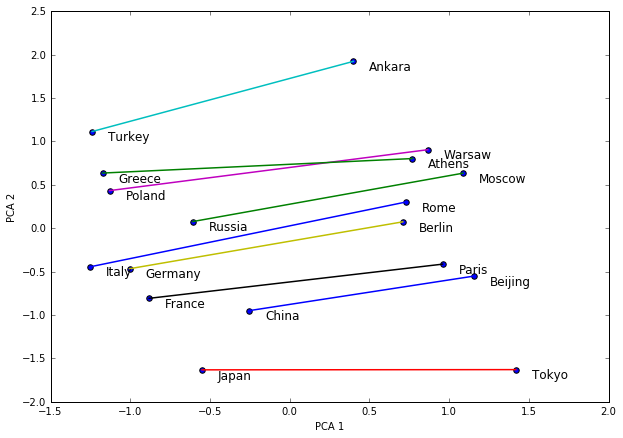

In [145]:
from sklearn import decomposition

words = ["China", "Beijing", "Russia", "Moscow", "Japan", "Tokyo", "Turkey", "Ankara", "Poland", "Warsaw", "Germany", "Berlin", "France", "Paris", "Italy", "Rome", "Greece", "Athens"]
X = model[words]

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], s = 30)

# annotations
for i in range(len(words)):
    eps = .1
    plt.text(X[i, 0] + eps, X[i, 1] - eps, words[i], fontsize = 12)

for i in range(len(words)):
    if i % 2 == 0:
        plt.plot(X[i:(i + 2), 0], X[i:(i + 2), 1], linewidth = 1.5)
    
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Find word synonyms

In [ ]:
model.most_similar(positive=['great'], topn=10)

Perform algebraic calculus in the embedding space

In [ ]:
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

In [ ]:
model.most_similar(positive=['Messi', 'tennis'], negative=['football'], topn=5)

Other fun functionnalities

In [ ]:
model.doesnt_match("Debussy Satie Ravel Bach".split())

In [ ]:
model.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])

Illustration of the algorithm on news articles
------------------------------
Load some articles related to sports or politics

In [7]:
with open(data_path + "sport1.txt", encoding='utf-8') as f:
    sport1 = f.read()
with open(data_path + "sport2.txt", encoding='utf-8') as f:
    sport2 = f.read()
with open(data_path + "politics1.txt", encoding='utf-8') as f:
    politics1 = f.read()
with open(data_path + "politics2.txt", encoding='utf-8') as f:
    politics2 = f.read()

array([[ 3.17960085,  3.00464117,  2.98006177,  3.47547887,  3.40356802,
         3.51069357,  2.86673376,  3.13844498,  3.02719937,  3.52843742,
         3.41696749,  2.9675529 ,  3.23956903,  3.7306532 ,  3.37666687,
         3.58538278,  3.22045194,  3.59128535,  2.77774602,  2.83868129,
         2.97110435,  2.80962364,  3.11266511,  3.09630885,  3.03864862,
         3.83286946,  2.94025447,  2.90449921,  3.42703267,  3.02295638,
         3.49994481,  3.51999557,  3.01399717,  3.24602754,  3.39829723,
         2.6232439 ,  3.03406465,  3.06383347,  3.40152698,  3.18901259,
         3.06587051,  3.35685926,  3.24826476,  3.52809152,  3.52959   ,
         3.2897755 ,  3.24230779,  3.06338378,  3.4974024 ,  3.11517948,
         3.01149047,  2.91194739,  3.4289691 ,  3.20045799,  3.01585022,
         3.93562134,  3.14223004,  3.21429235,  3.27908842,  3.09519142,
         3.24602754,  2.91915351,  2.72074483,  2.97997883,  2.86730362,
         2.87390908,  3.02584257,  2.95423443,  3.6

Compute pairwise distances

In [ ]:
print("Distance(sport1, sport2) = %.2f " %distance(sport1, sport2, 1, 100))
print("Distance(politics1, politics2) = %.2f " %distance(politics1, politics2, 1, 100))
print("Distance(sport1, politics2) = %.2f " %distance(sport1, politics2, 1, 100))
print("Distance(politics1, sport2) = %.2f " %distance(politics1, sport2, 1, 100))

Influence of $\lambda$ and the number of iterations: those parameters have to be tuned carefully demending on the type of documents we are dealing with.

In [ ]:
lambda_list = np.logspace(-2,2,10)
niter_list = [10, 50, 100, 300]
plt.figure(figsize = (16,12))
    
for it in range(len(niter_list)):
    niter = niter_list[it]
    results = np.zeros([len(lambda_list), 4])

    for i in range(len(lambda_list)):
        lambd = lambda_list[i]
        results[i, 0] =  distance(sport1, sport2, lambd, niter)
        results[i, 1] =  distance(politics1, politics2, lambd, niter)
        results[i, 2] =  distance(sport1, politics2, lambd, niter)
        results[i, 3] =  distance(politics1, sport2, lambd, niter)
    
    plt.subplot(2,2,it + 1)
    plt.plot(results[:, 0] , color = 'red')
    plt.plot(results[:, 1] , color = 'blue')
    plt.plot(results[:, 2] , 'r--', color = 'black')
    plt.plot(results[:, 3] , 'r-.', color = 'black')
    plt.xticks(np.arange(10), np.around(lambda_list, 2))
    plt.xlabel("$\lambda$")
    plt.ylabel("Distance")
    plt.title("Number of iterations: %d" %niter)
    plt.legend(['sport1 - sport2', 'politics1 - politics2', 'sport1 - politics2', 'politics1 - sport2'], loc=4)

Influence of the regularization parameter
---------------------------------------------

Influence of the embedding metric
------------------------------------

In [48]:
idx = np.argsort([2, 4, 1])

In [49]:
idx

array([2, 0, 1])

In [50]:
t = np.asarray([1, 2, 3])
Counter(t[idx])

Counter({1: 1, 2: 1, 3: 1})

In [41]:
t

array([], dtype=float64)